# **Image Classification using OpenCV DNN**

1. Importing Required Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import json
import torch

In [ ]:
# Print version of OpenCV
print("OpenCV:", cv2.__version__)

OpenCV: 4.12.0


2. Downloading and Loading the ONNX Model

Downloads a pre-trained MobileNetV2 model in ONNX format.
MobileNetV2 is lightweight and ideal for embedded systems like Raspberry Pi.

In [ ]:
!wget -O mobilenetv2.onnx https://github.com/onnx/models/raw/main/validated/vision/classification/mobilenet/model/mobilenetv2-7.onnx


--2025-11-25 12:19:02--  https://github.com/onnx/models/raw/main/validated/vision/classification/mobilenet/model/mobilenetv2-7.onnx
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/validated/vision/classification/mobilenet/model/mobilenetv2-7.onnx [following]
--2025-11-25 12:19:02--  https://media.githubusercontent.com/media/onnx/models/main/validated/vision/classification/mobilenet/model/mobilenetv2-7.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14246826 (14M) [application/octet-stream]
Saving to: ‘mobilenetv2.onnx’

mobilenetv2.onnx    100%[=============

Load the model

OpenCV loads the ONNX model into its DNN engine.

In [ ]:
# Load ONNX model
net = cv2.dnn.readNetFromONNX("mobilenetv2.onnx")
print(" Model loaded successfully!")


 Model loaded successfully!


3. Selecting CPU/GPU Inference Backend

In [ ]:
USE_GPU = False  # Set to False to force CPU
DEVICE = "cuda" if (USE_GPU and torch.cuda.is_available()) else "cpu"

if DEVICE == "cuda":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print(" Running on GPU (CUDA)")
else:
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    print(" Running on CPU")


 Running on CPU


4. Downloading ImageNet Labels

This file contains human-readable ImageNet class names.

In [ ]:
# Download the label file (contains ImageNet class names)
!wget -O classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

# Load the labels from the JSON file
with open("classification_classes_ILSVRC2012.txt") as f:
    labels = json.load(f)

--2025-11-25 12:19:21--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14209 (14K) [text/plain]
Saving to: ‘classification_classes_ILSVRC2012.txt’

classification_clas 100%[===================>]  13.88K  --.-KB/s    in 0.001s  

2025-11-25 12:19:21 (12.6 MB/s) - ‘classification_classes_ILSVRC2012.txt’ saved [14209/14209]



5. Image Classification Function

The input_images() function loads an image, preprocesses it for MobileNetV2, performs classification using the ONNX model, displays the image with the predicted label, and prints the confidence, inference time, and memory usage.

In [ ]:
# Function to process a single image
def input_images(image_path):

    # Load the input image
    img = cv2.imread(image_path)
    if img is None:
        print(f" Could not read {image_path}")
        return
    # Convert BGR (OpenCV default) to RGB (for proper display)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to the required input size of MobileNetV2 (224x224)
    resized = cv2.resize(img_rgb, (224, 224))

    #Preprocess image into blob
    blob = cv2.dnn.blobFromImage(
        image=resized,
        scalefactor=1/127.5,           # Normalize pixels to [-1, 1]
        size=(224, 224),               # Input size for MobileNetV2
        mean=(127.5, 127.5, 127.5),    # Mean subtraction for normalization
        swapRB=True,                   # Convert OpenCV BGR → RGB
        crop=False                     # Do not crop the image
    )

    # Set the blob as input to the network
    net.setInput(blob)

    # Perform forward pass (inference)
    start = time.time()
    out = net.forward()  # Run model
    inference_time = (time.time() - start) * 1000  # ms

    # Post-process model output
    out = out.flatten()  # Flatten from 2D to 1D (1000 classes)

    # Apply softmax to get probabilities
    probabilities = np.exp(out - np.max(out))
    probabilities = probabilities / np.sum(probabilities)

    # Find class with highest probability
    class_id = np.argmax(probabilities)
    confidence = probabilities[class_id]
    label = labels[class_id]

    # Overlay prediction on image
    output_img = img_rgb.copy()
    text = f"{label} ({confidence*100:.2f}%)"
    cv2.putText(output_img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)

    # Display the image with prediction
    plt.figure(figsize=(6,6))
    plt.imshow(output_img)
    plt.axis("off")
    plt.title(f"{image_path}")
    plt.show()

    # Print results and system stats
    print(f"Predicted: {label} ({confidence*100:.2f}%)")
    print(f"Inference time: {inference_time:.2f} ms")

    # Memory usage
    process = psutil.Process()
    mem_mb = process.memory_info().rss / 1024 / 1024
    print(f"Memory used: {mem_mb:.2f} MB\n")



6. Running the Classifier

Example 1:

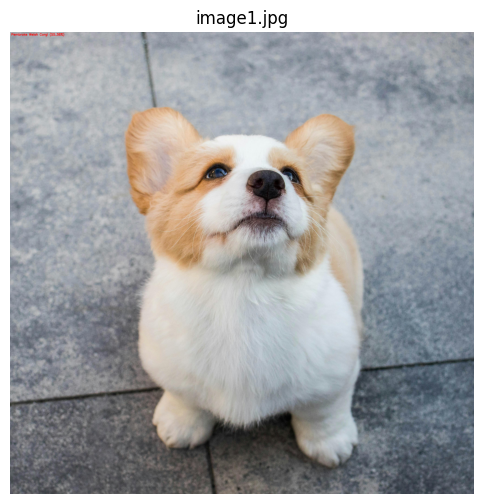

Predicted: Pembroke Welsh Corgi (55.38%)
Inference time: 69.69 ms
Memory used: 542.72 MB



In [ ]:
input_images("image1.jpg")

Example 2:

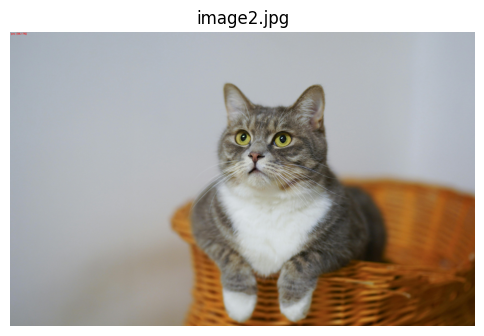

Predicted: lynx (66.17%)
Inference time: 28.89 ms
Memory used: 613.23 MB



In [ ]:
input_images("image2.jpg")